In [1]:
import pandas as pd
import featuretools as ft
from eda_functions import correlation_matrix, plot_time_data, feature_importance_plot

              Open      High       Low     Close    Volume  Humidity
Open      1.000000  0.998446  0.998101  0.996506  0.165758 -0.020825
High      0.998446  1.000000  0.997980  0.998526  0.175429 -0.018170
Low       0.998101  0.997980  1.000000  0.998357  0.148922 -0.019495
Close     0.996506  0.998526  0.998357  1.000000  0.160216 -0.017039
Volume    0.165758  0.175429  0.148922  0.160216  1.000000 -0.005648
Humidity -0.020825 -0.018170 -0.019495 -0.017039 -0.005648  1.000000


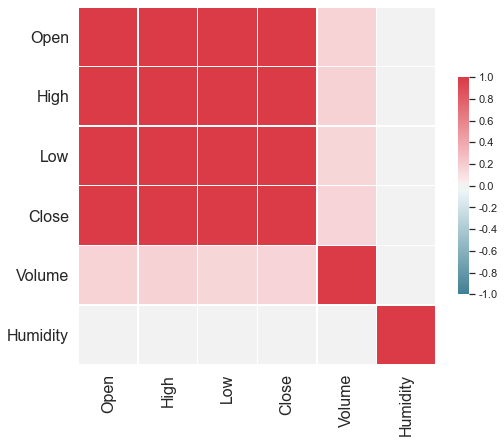

In [2]:
path_datafile = r'data/rice_prices.csv'
data_raw = pd.read_csv(path_datafile)

cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Fundamental_news', 'Market_sentiment', 'Humidity']
# see what to do about the data
cols_numeric_features = ['Open', 'High', 'Low', 'Volume', 'Humidity']
cols_categoric_features = ['Fundamental_news', 'Market_sentiment']

cols_target = 'Close'
correlation_matrix(data_raw[['Open', 'High', 'Low', 'Close', 'Volume', 'Humidity']], to_show=True)

Appears that Open, High and Low are extremely correlative. While some correlation is to be<br>
expected, such a high correlation (> 0.99) is surprising.<br>
They are also extremely correlative with 'Close' which is our target variable<br>
This probably means that, usually, on a daily basis, the stock doesn't change all that much<br>

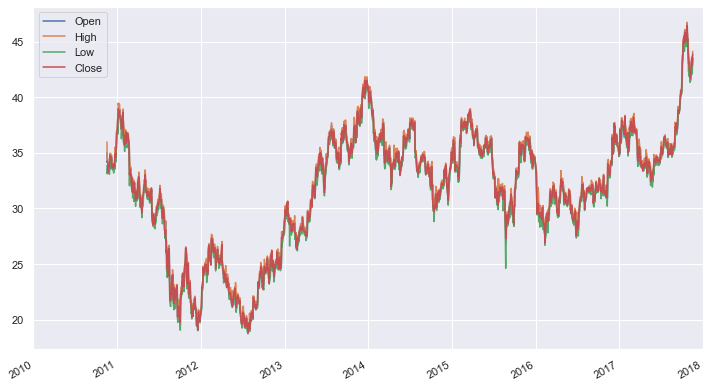

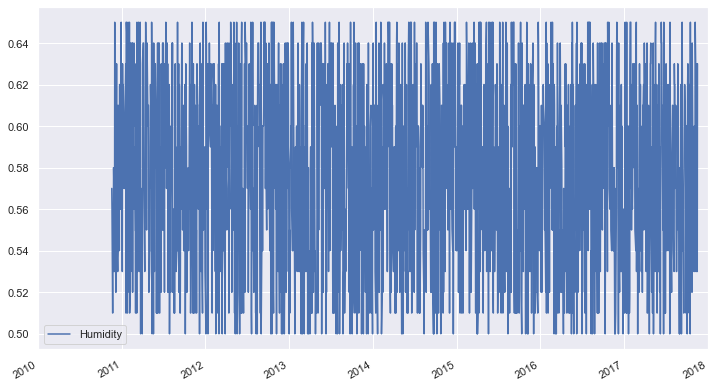

In [3]:
plot_time_data(data_raw['Date'], data_raw[['Open', 'High', 'Low', 'Close']], to_show=True)
plot_time_data(data_raw['Date'], data_raw[['Humidity']], to_show=True)


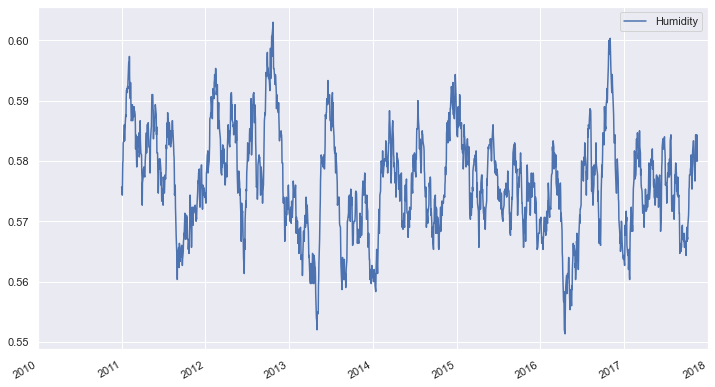

In [7]:
running_humidity = data_raw[['Humidity']].rolling(window=30).mean()
plot_time_data(data_raw['Date'], running_humidity, to_show=True)

As we suspected, we see that the prices are extremely well correlated, on a daily basis.<br>
Humidity seems to have some sort of periodicity, but it is not immediately obvious how<br>

Feature generation using several basic transformations of the <b>featuretools</b> package.<br>
A domain expert might have easier time adding various feature that are more informative.<br>
For the time being, we'll stick with the basics

In [8]:
df_processed = data_raw.copy(deep=True)
df_processed['Date'] = pd.to_datetime(df_processed['Date'])
es = ft.EntitySet(id='prices')
es = es.entity_from_dataframe(entity_id='prices', dataframe=data_raw, make_index=True, index='tmp_idx', time_index='Date',
                              variable_types={'Fundamental_news': ft.variable_types.Categorical,
                                              'Market_sentiment': ft.variable_types.Categorical
                                              }
                              )
print(es)
print(es['prices'])

Entityset: prices
  Entities:
    prices [Rows: 1763, Columns: 10]
  Relationships:
    No relationships
Entity: prices
  Variables:
    tmp_idx (dtype: index)
    Date (dtype: datetime_time_index)
    Open (dtype: numeric)
    High (dtype: numeric)
    Low (dtype: numeric)
    Close (dtype: numeric)
    Volume (dtype: numeric)
    Humidity (dtype: numeric)
    Fundamental_news (dtype: categorical)
    Market_sentiment (dtype: categorical)
  Shape:
    (Rows: 1763, Columns: 10)


In [9]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="prices",
                                      ignore_variables={
                                           "prices": ['Close']
                                      },
                                      trans_primitives=['cum_min', 'cum_max', 'divide_by_feature', 
                                                        'multiply_numeric', 'month', 'weekday', 'is_weekend'],
                                      max_depth=3,
                                      verbose=1
                                      )

feature_matrix.reset_index(inplace=True, drop=True)

feature_matrix.to_csv('data/dfs/features.csv', index=False)
df_processed[[cols_target]].to_csv('data/dfs/y_label.csv', index=False)

Built 640 features
Elapsed: 00:00 | Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████


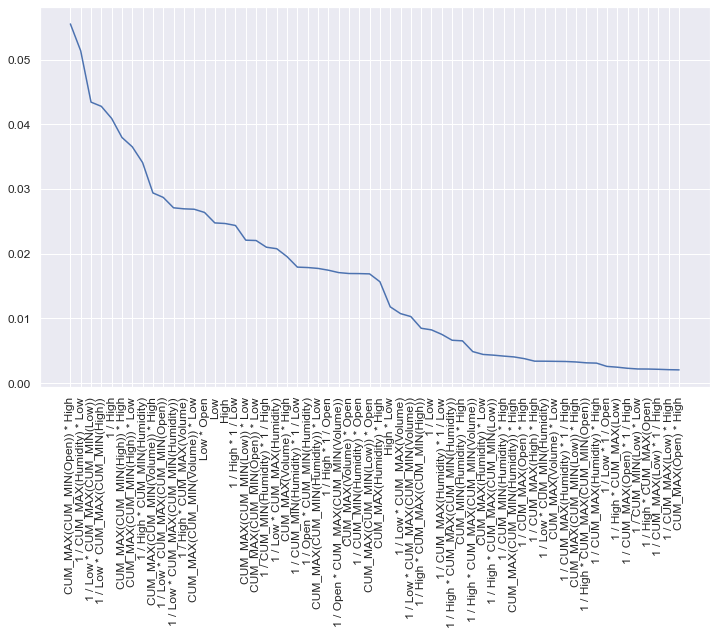

,Feature,Importance
619,CUM_MAX(CUM_MIN(Open)) * High,0.055508
505,1 / CUM_MAX(Humidity) * Low,0.051347
470,1 / Low * CUM_MAX(CUM_MIN(Low)),0.043421
614,1 / Low * CUM_MAX(CUM_MIN(High)),0.042768
20,1 / High,0.040894
...,...,...
519,CUM_MAX(CUM_MIN(High)) * CUM_MAX(CUM_MIN(Volume)),0.000000
520,1 / CUM_MIN(Volume) * CUM_MIN(Volume),0.000000
243,1 / CUM_MAX(Volume) * 1 / CUM_MIN(High),0.000000
522,CUM_MAX(CUM_MIN(Volume)) * CUM_MAX(Volume),0.000000


In [10]:
feature_importance_plot(feature_matrix, y_true=df_processed[cols_target])